In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
sys.path.append("../../fermi-gce-gp/")
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [6]:
ps_mask = np.load("../../fermi-gce-gp/data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/smsharma/anaconda3/lib/python3.7/site-packages/healpy-1.12.9-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


torch.Size([1, 16384, 1])

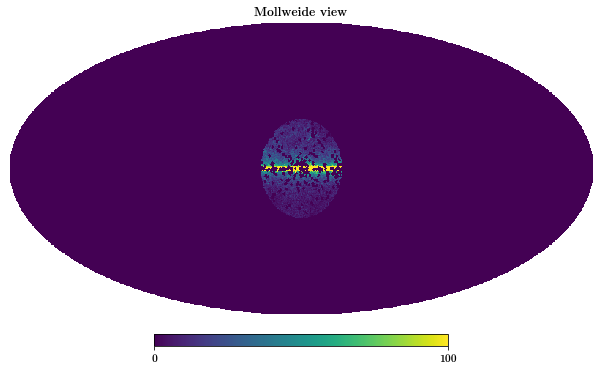

In [7]:
in_map = np.load("../../fermi-gce-gp/data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [9]:
sg = SphericalGraphCNN(nside_list, indexes_list).to(device)

In [10]:
in_map.shape

torch.Size([1, 16384, 1])

In [11]:
in_map = in_map.to(device)

In [12]:
sg(in_map).shape

torch.Size([1, 512])

In [14]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")

In [15]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from utils.utils import make_dirs
from models.psf import KingPSF

In [16]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [17]:
from simulations.wrapper import simulator

In [18]:
from sbi import utils
from sbi import inference
from sbi.inference.base import infer

In [21]:
theta = [3, 10., 1.9, -10., 20., 0.1]
simulator(theta, masks_list[0], temp_gce, pc_inst.psf_r_func)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
from tqdm import *

In [23]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.5, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([3.0, 20.0, 1.9, 1.9, 50.0, 4.99]))

In [26]:
number_presimulated = 10

theta_presimulated = prior.sample((number_presimulated,))
x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func) for theta in tqdm(theta_presimulated)]



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:02,  4.48it/s]

 20%|██        | 2/10 [00:00<00:01,  5.05it/s]

 30%|███       | 3/10 [00:00<00:01,  4.95it/s]

 40%|████      | 4/10 [00:00<00:01,  5.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.90it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.65it/s]

100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


In [21]:
theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train.npy")[:50000]
x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train.npy")[:50000]

In [69]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [70]:
theta_presimulated[:, 0] = torch.log10(theta_presimulated[:, 0])

In [71]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

In [72]:
simulator_model = lambda theta: simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func)

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = inference.prepare_for_sbi(simulator_model, prior)

# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = inference.SNPE(simulator_wrapper, prior,
                           density_estimator=neural_classifier, 
                           show_progress_bars=True, show_round_summary=True, 
                           logging_level='INFO',
                             sample_with_mcmc=False,
                             mcmc_method="slice_np",
                             device=device)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/sbi-0.12.2-py3.7.egg/sbi/utils/torchutils.py:42: UserWarning: GPU was selected as a device for training the neural network. Note 
                that we expect **no** significant speed ups in training for the default
            architectures we provide. Using the GPU will be effective only for large
            neural networks with operations that are fast on the GPU, e.g.,
            for CNN or RNN embeddings.
  for CNN or RNN embeddings."""


In [73]:
inference_inst.provide_presimulated(theta_presimulated, x_presimulated[:, 0, :])

In [74]:
# run the inference procedure on one round and 10000 simulated data points
posterior = inference_inst(num_simulations=0, training_batch_size=64, max_num_epochs=2)

 Training neural network. Epochs trained:  3
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 3
        Best validation performance: -16.9098
        Acceptance rate: nan
        -------------------------
        


In [40]:
torch.save(posterior, "/Users/smsharma/Desktop/test.pt")

In [45]:
posterior = torch.load("/Users/smsharma/Desktop/test.pt")

In [47]:
idx = 2

true_parameter = theta_presimulated[idx]
x_observed = x_presimulated[idx]

true_parameter

tensor([ 2.1330, 19.6724,  1.3208, -8.1124, 10.8828,  2.4071])

In [50]:
# generate posterior samples
# true_parameter = torch.tensor([2.5, 10., 1.9, -10., 20., 0.1])
# x_observed = simulator_model(true_parameter)

true_parameter = theta_presimulated[2]
x_observed = x_presimulated[2]

samples = posterior.set_default_x(x_observed).sample((500,), sample_with_mcmc=False)

                        prior support. It may take a long time to collect the remaining
                        500 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


Tuning bracket width...:   0%|          | 0/50 [00:19<?, ?it/s]

KeyboardInterrupt: 

In [78]:
import corner

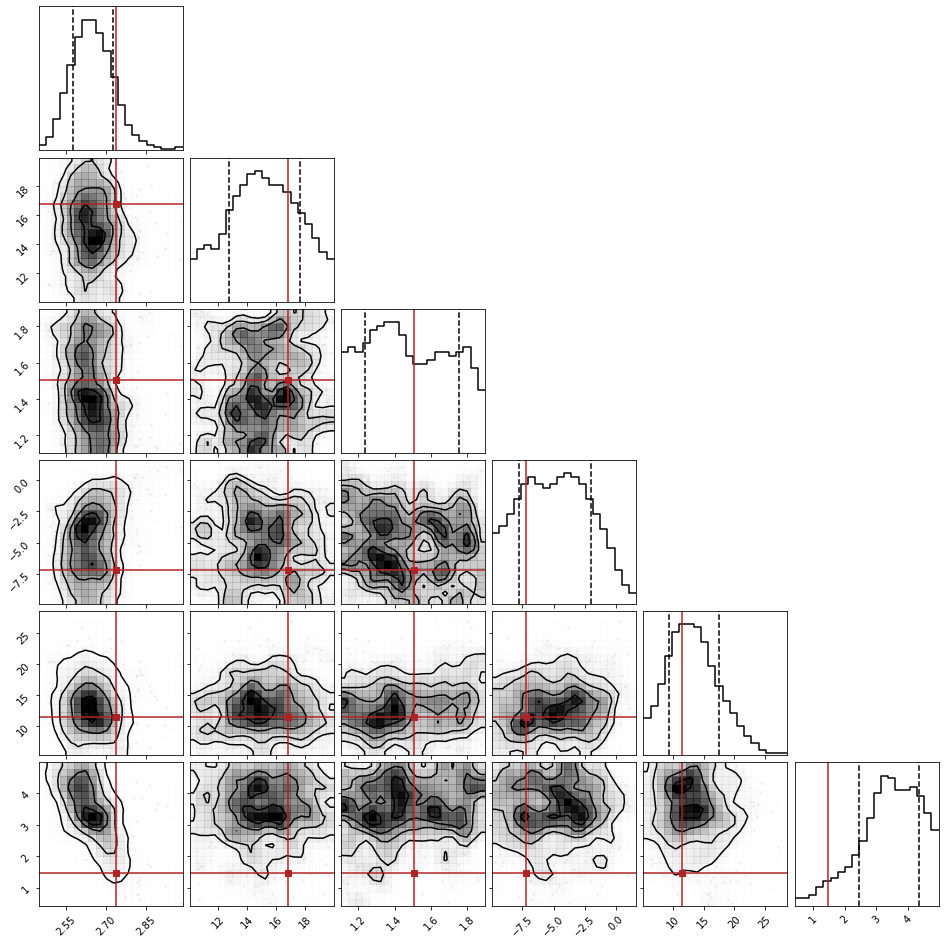

In [94]:
corner.corner(samples, truths=true_parameter, smooth=1, smooth1d=1, truth_color='firebrick', quantiles=(0.16, 0.84));